In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

#Cuda 혹은 cpu를 사용하시오.
############Write Your Code Here############
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
# print(f"using device: {device}")
############################################


#Custom_Dataset을 정의하시오.(10점)
class Custom_Dataset(Dataset):
    def __init__(self, X, y):
        #입력으로 들어온 X의 pixel값들을 0-1사이로 normalize하고 X의 shape을 (FB,C,H,W)로 변경하여 저장하여 self.X,self.y에 저장하시오.
        self.X = None
        self.y = None
        ############Write Your Code Here############
        # 파라미터로 받은 X, y의 데이터타입을 np.float으로 변환후 
        # 255.0으로 나눠 0-1 사이로 normalize 합니다.
        X = X.astype(np.float64)
        X /= 255.
        # X의 shape을 받아서(FB, H, W, C) 알맞게(FB,C,H,W) 변환합니다.
        (FB, H, W, C) = X.shape
        X = X.reshape((FB,C,H,W))
        self.FB = FB # __len__ 메서드를 위해 클래스 변수로 저장합니다.
        self.X = X
        self.y = y
        ############################################
        
    def __len__(self):
        #Custom_Dataset에 저장되어있는 총 data의 개수를 result에 저장하여 반환하시오.
        result = 0
        ############Write Your Code Here############
        result = self.FB
        ############################################
        return result
    
    def __getitem__(self, idx):
        #self.X, self.y 에서 idx에 맞는 data를 result_X,result_y에 저장하여 반환하시오.
        result_X,result_y = None,None
        ############Write Your Code Here############
        result_X,result_y = self.X[idx], self.y[idx]
        ############################################
        return result_X,result_y


#torch.nn을 사용하여 아래 함수들을 작성하시오. result는 nn.Layer중 하나이고 result를 반환함.(20점)
def batch_norm(dim,for_MLP=True):
    #for_MLP가 True일 시 MLP를 위한 BN Layer를 반환하고 False일 시 CNN을 위한 BN Layer를 반환함.
    ############Write Your Code Here############
    if for_MLP:
      result = nn.BatchNorm1d(num_features=dim)
    else:
      result = nn.BatchNorm2d(num_features=dim)
    ############################################
    return result

def fc_layer(in_dim,out_dim):
    #Fully Connected Layer(Dense Layer)
    ############Write Your Code Here############
    result = nn.Linear(in_features=in_dim, out_features=out_dim)
    ############################################
    return result

def conv_layer(in_ch,out_ch,kernel_size=3, stride=1, padding=1):
    #Convolutional Layer for image
    ############Write Your Code Here############
    result =  nn.Conv2d(in_channels=in_ch, 
              out_channels=out_ch,
              kernel_size=kernel_size,
              stride=stride, 
              padding=padding)
    ############################################
    return result

def relu():
    #ReLU function
    ############Write Your Code Here############
    result = nn.ReLU()
    ############################################
    return result

def flatten():
    #Flatten the data
    ############Write Your Code Here############
    result = nn.Flatten()
    ############################################
    return result


#skip_connection(bn -> relu -> conv -> bn -> relu -> conv)를 따르는 Res_block을 만드시오.
#change_res가 True인 res_block을 통과한 feature map은 resolution이 2배 작아지고 channel의 깊이는 2배로 증가함. ex) 32*8*8 -> 64*4*4
#위의 경우에는 skip_connection의 dimension은 1*1 conv로 맞춰줌.
#change_res가 False인 Res_block을 통과한 feature map은 resolution과 channel의 깊이는 그대로 유지됨. ex) 32*4*4 -> 32*4*4(20점)
class Res_block(nn.Module):
    # https://github.com/pytorch/vision/blob/a9a8220e0bcb4ce66a733f8c03a1c2f6c68d22cb/torchvision/models/resnet.py#L101
    def __init__(self, input_channel, change_res):
        super(Res_block,self).__init__()
        self.change_res = change_res
        if change_res:
            ############Write Your Code Here############
            self.downsample = conv_layer(in_ch=input_channel, 
                                         out_ch=input_channel*2, 
                                         stride=2) 
            ############################################
        else:
            ############Write Your Code Here############
            self.downsample = None
            ############################################
        ############Write Your Code Here############
        self.bn1 = batch_norm(dim=input_channel,for_MLP=False)
        self.relu1 = relu()
        self.conv1 = conv_layer(in_ch=input_channel, out_ch=input_channel)
        self.bn2 = batch_norm(dim=input_channel,for_MLP=False)
        self.relu2 = relu()
        self.conv2 = conv_layer(in_ch=input_channel, out_ch=input_channel)   
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        
        identity = X.float()

        X = self.conv1(X.float())
        X = self.bn1(X)
        X = self.relu1(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X += identity
        X = self.relu2(X)

        if self.downsample is not None:
          X = self.downsample(X)
        ############################################
        return X


#Skip Connection을 이용하여 20개 이상의 layer를 가지고 테스트 셋에대하여 50% 이상의 성능을 주는 MLP를 만드시오.
#nn.ModuleList를 사용하면 많을 층의 layer를 쌓는데 용이함.(20점)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP,self).__init__()
        ############Write Your Code Here############
        self.bn0 = batch_norm(input_dim, for_MLP=True)
        self.linear1 = fc_layer(input_dim, 512)
        self.linear2 = fc_layer(512, 256)
        self.linear3 = fc_layer(256, 256)
        self.bn3 = batch_norm(256,for_MLP=True)
        self.linear4 = fc_layer(256, 128)
        self.linear5 = fc_layer(128, 64)
        self.linear6 = fc_layer(64, 64)
        self.bn6 = batch_norm(64,for_MLP=True)
        self.linear7 = fc_layer(64, output_dim)
        self.relu_layer = relu()
        ############################################
    def forward(self, X):
        ############Write Your Code Here############
        X = X.view(X.size(0), -1)
        X = self.bn0(X)
        X = self.linear1(X)
        X = self.relu_layer(X)

        X = self.linear2(X)
        X = self.relu_layer(X)
        id = X 

        X = self.linear3(X)
        X = self.relu_layer(X)
        X += id

        # X = self.relu_layer(X)
        X = self.bn3(X)
        X = self.linear4(X)
        X = self.relu_layer(X)
        
        X = self.linear5(X)
        X = self.relu_layer(X)

        id = X
        X = self.linear6(X)
        X = self.relu_layer(X)

        X += id
        # X = self.relu_layer(X)
        X = self.bn6(X)
        X = self.linear7(X)
        X = self.relu_layer(X)
        ############################################
        return X



#Res_Block을 사용하여 테스트 셋에대한 70% 이상의 성능을 주는 CNN 모델을 만드시오.
#flatten전에 nn.AdaptiveAvgPool2d를 사용하면 dimension맞추기가 쉬움.(20점)
class CNN(nn.Module):
    def __init__(self, input_channel, class_number, block_number):
        super(CNN,self).__init__()
        ############Write Your Code Here############
        # https://dnddnjs.github.io/cifar10/2018/10/09/resnet/
        def get_layers(in_channels, block_number, change_res):
            layers_list = nn.ModuleList()
            for _ in range(block_number - 1):
                layers_list.append(Res_block(in_channels, False))
            layers_list.append(Res_block(in_channels, change_res))
            return nn.Sequential(*layers_list)

        self.conv1 = conv_layer(in_ch=input_channel, out_ch=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = batch_norm(64, for_MLP=False)
        self.relu1 = relu()
  
        self.layers1 = get_layers(64, block_number[0], True)
        self.layers2 = get_layers(128, block_number[1], True)
        self.layers3 = get_layers(256, block_number[2], True)
        self.layers4 = get_layers(512, block_number[3], False)

        # output layers
        self.fc_out = fc_layer(8192, class_number)
        
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu1(X)
        
        X = self.layers1(X)
        X = self.layers2(X)
        X = self.layers3(X)
        X = self.layers4(X)

        X = X.view(X.size(0), -1)
        X = self.fc_out(X)
        ############################################
        return X


#loader에 있는 모든 data들에 대한 정확도를 구하여 accuracy에 저장하여 accuracy를 return하는 함수를 구현하시오.(10점)
def evaluate(model, loader):
    model.eval()
    accuracy = 0
    total_example = 0
    correct_example = 0
    for data in loader:
        x,y = data
        x = torch.tensor(x, device = device)
        y = torch.tensor(y, device = device)
        ############Write Your Code Here############
        # https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a
        x = x.type(torch.float)
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        total_example += y.size(0)
        correct_example += (predicted == y).sum().item()
        ############################################
    ############Write Your Code Here############
    accuracy = 100 * correct_example / total_example
    ############################################
    model.train()
    return accuracy

#epoch마다 train_loader에 있는 batch들을 사용하여 모델을 학습하고
#epoch의 마지막 iteration에서는 모델의 validation accuracy를 확인하여 제일 높은 val. acc.를 가진 model을 best_model에 저장하고
#val_acc에는 매 epoch마다 구해진 validation accuracy를 저장하시오.
#running_loss에는 각각의 epoch에서 모든 batch의 loss를 다 더하여 저장하시오.
#모든 epoch의 validation accuracy를 val_acc에 저장하여 best_model과 val_acc를 return하는 함수를 구현하시오.(10점)
def train(model, epoches, train_loader, val_loader, optimizer, criteria):
    best_score = 0
    best_model = None
    batch_len = len(train_loader)
    val_acc = []
    for epoch in range(epoches):
        running_loss = 0
        for i,data in enumerate(train_loader):
            x,y = data
            x = torch.tensor(x, device = device)
            y = torch.tensor(y, device = device)
            ############Write Your Code Here############
            x = x.type(torch.float)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criteria(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            ############################################
            
            #epoch의 마지막 iteration
            if i % batch_len == batch_len-1:
                print(f'{epoch+1}th iteration loss :',running_loss/batch_len)
                running_loss = 0
                ############Write Your Code Here############
                #val_acc에는 매 epoch마다 구해진 validation accuracy를 저장하시오.
                accuracy = evaluate(model, val_loader)
                val_acc.append(accuracy)
                #epoch의 마지막 iteration에서는 모델의 validation accuracy를 확인하여 제일 높은 val. acc.를 가진 model을 best_model에 저장하고
                if max(val_acc) == accuracy:
                    best_model = model
                ############################################
    return best_model, val_acc

Files already downloaded and verified
Files already downloaded and verified
1th iteration loss : 1.7741016008602544
2th iteration loss : 1.3786145136379206
3th iteration loss : 1.1387192159415054
4th iteration loss : 0.9116287475195937
5th iteration loss : 0.6979503514477239
6th iteration loss : 0.47212459575444365
7th iteration loss : 0.33351051312285107
8th iteration loss : 0.2560688198184053
9th iteration loss : 0.1612540849576743
10th iteration loss : 0.09254311538709048
11th iteration loss : 0.03733560079768205
12th iteration loss : 0.00930734690890228
13th iteration loss : 0.0017217169456279127
14th iteration loss : 0.0006998907573842488
15th iteration loss : 0.0004833472621874116
16th iteration loss : 0.0003910604032621639
17th iteration loss : 0.0003427403855149429
18th iteration loss : 0.0002909112649061494
19th iteration loss : 0.0002692327266536689
20th iteration loss : 0.00025082542737663244
21th iteration loss : 0.00022298155153302636
22th iteration loss : 0.00021033066798

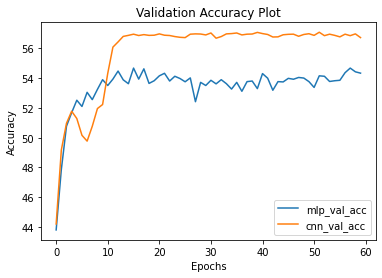

In [2]:
#(50점)
#Read the data
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True)

X_train, Y_train = trainset.data, np.array(trainset.targets)
X_test, Y_test = testset.data, np.array(testset.targets)


#앞서 정의한 Custom_Dataset과 DataLoader를 사용하여 train_loader,val_loader,test_loader를 정의하시오.
#Batch_size는 본인의 컴퓨터 사향에 맞게 변경하면 됨. Validation Set으로 Train Set의 20%를 사용함.
#Preprocessing
train_loader = None
val_loader = None
test_loader = None
batch_size = 1
############Write Your Code Here############
batch_size = 128
test_dataset = Custom_Dataset(X_test, Y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
train_val_dataset = Custom_Dataset(X_train, Y_train)
train_dataset, validation_dataset = torch.utils.data.random_split(train_val_dataset, [40000, 10000])
val_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
############################################


#앞서 정의한 MLP,CNN을 사용하여 mlp_model,cnn_model을 정의하시오.
#Define the model
mlp_model = None
cnn_model = None
############Write Your Code Here############
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore") 
mlp_model = MLP(3*32*32, 10)
cnn_model = CNN(input_channel=3, class_number=10, block_number=[2, 2, 2, 2])
criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=0.02, momentum=0.9)
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
############################################
mlp_model.to(device)
cnn_model.to(device)


#앞서 정의한 train함수를 사용하여 best_mlp, mpl_val_acc, best_cnn, cnn_val_acc를 구하시오.
#Train the model
best_mlp = None
mlp_val_acc = None
best_cnn = None
cnn_val_acc = None
############Write Your Code Here############
epoches = 60
best_cnn, cnn_val_acc = train(cnn_model, epoches, train_loader, val_loader, cnn_optimizer, criterion)
best_mlp, mlp_val_acc = train(mlp_model, epoches, train_loader, val_loader, mlp_optimizer, criterion)
############################################


#앞서 정의한 evaluate함수와 best_model들을 사용하여 mlp_acc, cnn_acc를 구하시오.
#Test Accuracy
mlp_acc = None  
cnn_acc = None 
############Write Your Code Here############
mlp_acc = evaluate(best_mlp, test_loader)
cnn_acc = evaluate(best_cnn, test_loader)
############################################
print('MLP accuracy:',mlp_acc)
print('CNN accuracy:',cnn_acc)


#앞서 구한 val_acc들을 사용하여 이해 가능한 그래프를 그리시오.
#Validation Accuracy Plot
############Write Your Code Here############
plt.plot(mlp_val_acc)
plt.plot(cnn_val_acc)
plt.legend(['mlp_val_acc', 'cnn_val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Plot')
plt.show()
############################################